In [2]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    t = df['time_to_order_seconds']
    
    # 3. Нелинейные преобразования
    df['ttos_sq'] = t ** 2
    df['ttos_cube'] = t ** 3
    # логарифм с сохранением знака
    df['ttos_log'] = np.sign(t) * np.log1p(np.abs(t))
    
    # 4. Квантили и бины
    # Децильный бин
    df['ttos_decile'] = pd.qcut(t, 10, labels=False, duplicates='drop')
    # Простая категоризация по минутам
    df['ttos_short']  = (t.abs() <= 60).astype(int)        # <= 1 мин
    df['ttos_medium'] = ((t.abs() > 60) & (t.abs() <= 300)).astype(int)  # 1–5 мин
    df['ttos_long']   = (t.abs() > 300).astype(int)        # > 5 мин
    

    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    
    df['session_hour']       = df[session_end_col].dt.hour
    df['session_dow']        = df[session_end_col].dt.dayofweek
    df['session_dom']        = df[session_end_col].dt.day
    df['session_month']      = df[session_end_col].dt.month
    df['session_week']       = df[session_end_col].dt.isocalendar().week
    df['session_is_weekend'] = df['session_dow'] >= 5
    
    # 6. Циклическое кодирование
    df['order_hour_sin'] = np.sin(2 * np.pi * df['order_hour'] / 24)
    df['order_hour_cos'] = np.cos(2 * np.pi * df['order_hour'] / 24)
    df['order_day_of_week_sin']  = np.sin(2 * np.pi * df['order_day_of_week']  / 7)
    df['order_day_of_week_cos']  = np.cos(2 * np.pi * df['order_day_of_week']  / 7)
    
    df['session_hour_sin'] = np.sin(2 * np.pi * df['session_hour'] / 24)
    df['session_hour_cos'] = np.cos(2 * np.pi * df['session_hour'] / 24)
    df['session_dow_sin']  = np.sin(2 * np.pi * df['session_dow']  / 7)
    df['session_dow_cos']  = np.cos(2 * np.pi * df['session_dow']  / 7)
    
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    df['gap_negative'] = df['time_to_order_seconds'] < 0
    df['is_midnight_session'] = df['session_end_hour'].isin([0, 1, 2, 3])
    df['order_during_business_hours'] = df['order_hour'].between(9, 18)
    
    df['hour_diff'] = df['session_end_hour'] - df['order_hour']

    df['order_time_fraction'] = df[order_time_col].dt.hour * 3600 + df[order_time_col].dt.minute * 60 + df[order_time_col].dt.second
    df['order_time_fraction'] /= 86400  # нормировка по числу секунд в сутках

    
    # сезон
    def season(m):
        if m in (12,1,2):  return 'winter'
        if m in (3,4,5):   return 'spring'
        if m in (6,7,8):   return 'summer'
        return 'autumn'
    df['order_season']        = df['order_month'].map(season)
    df['session_end_season']  = df['session_month'].map(season)
    
    # 8. Простейшие фичи-интеракции
    df['ttos_x_hour']      = t * df['order_hour']
    df['ttos_x_dow']       = t * df['order_day_of_week']
    
    # дробная часть дня (норм.)
    frac = (df[order_time_col].dt.hour * 3600 +
            df[order_time_col].dt.minute * 60 +
            df[order_time_col].dt.second)
    df['order_time_frac'] = frac / 86400
    
    return df

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# 1) Загрузка
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

target = tr.pop('target')
order_id = tst.pop('order_id')

tr = create_time_features(tr)
tst = create_time_features(tst)

# удаляем исходные метки времени
tr = tr.drop(columns=['order_create_time', 'session_end_time'])
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

# 2) Первый уровень: rule-based фильтр
threshold_hard = -400
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['hard_call'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

# 3) приводим object → category для ВСЕХ нужных колонок
#    это должны быть колонки из tr.select_dtypes(object) и session_end_time_of_day и т.п.
cat_cols = tr.select_dtypes(include=['object']).columns.tolist() + [
    'order_time_of_day', 'session_end_time_of_day'
]
cat_cols = list(set(cat_cols))  # убрать дубли

for col in cat_cols:
    # ТОЛЬКО если колонка есть в датафрейме
    if col in tr.columns:
        tr[col]  = tr[col].astype('category')
        tst[col] = tst[col].astype('category')

# 4) Разделяем на «сложные» и «очевидные» кейсы
mask = tr['hard_call'] == 0
X_soft = tr[mask]
y_soft = target[mask]

#-------------------------------------------------------------------------
#-----------------------------------SOFT----------------------------------
#-------------------------------------------------------------------------

# 5) train/val split для «сложных»
X_train, X_val, y_train, y_val = train_test_split(
    X_soft, y_soft, test_size=0.2, stratify=y_soft, random_state=42
)

# 6) Dataset для LGBM
train_data = lgb.Dataset(
    X_train, label=y_train,
    categorical_feature=cat_cols
)
val_data = lgb.Dataset(
    X_val, label=y_val,
    categorical_feature=cat_cols,
    reference=train_data
)

# 7) Тренировка
params = {
    'objective':'binary', 'metric':'auc',
    'boosting_type':'gbdt', 'learning_rate':0.05,
    'num_leaves':31, 'feature_fraction':0.8,
    'bagging_fraction':0.8, 'bagging_freq':5,
    'max_depth':6, 'seed':42, 'verbose':-1
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	],
)

print("Soft AUC:", roc_auc_score(y_val, model.predict(X_val)))

#-------------------------------------------------------------------------
#-----------------------------------HARD----------------------------------
#-------------------------------------------------------------------------

# Обучаем модель на hard-примерах
X_hard = tr[~mask]  # где hard_call == 1
y_hard = target[~mask]

X_hard_train, X_hard_val, y_hard_train, y_hard_val = train_test_split(
    X_hard, y_hard, test_size=0.2, stratify=y_hard, random_state=42
)

train_data_hard = lgb.Dataset(
    X_hard_train, label=y_hard_train,
    categorical_feature=cat_cols
)
val_data_hard = lgb.Dataset(
    X_hard_val, label=y_hard_val,
    categorical_feature=cat_cols,
    reference=train_data_hard
)

# Можно чуть изменить параметры, например увеличить глубину
params_hard = {
    'objective':'binary',
	'metric':'auc',
	'boosting_type':'gbdt',
	'learning_rate':0.047370678549250644,
	'num_leaves':3,
	'feature_fraction':0.6443136359902204,
	'bagging_fraction':0.7439504624342974,
	'bagging_freq':2,
	'max_depth':11,
    'min_child_samples': 64,
	'seed':42,
	'verbose':-1,
}

model_hard = lgb.train(
    params_hard,
    train_data_hard,
    num_boost_round=500,
    valid_sets=[train_data_hard, val_data_hard],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=50)
    ],
)

print("Hard AUC:", roc_auc_score(y_hard_val, model_hard.predict(X_hard_val)))




# 8) Финальный predict: rule-based + LGBM
def predict_full(df):
    """
    Предсказывает is_callcenter, используя две модели:
    - LGB для 'легких' (hard_call == 0)
    - LGB для 'трудных' (hard_call == 1)
    """
    preds = np.zeros(df.shape[0])
    
    mask_hard = df['hard_call'] == 1
    mask_soft = ~mask_hard

    preds[mask_soft] = model.predict(df[mask_soft], num_iteration=model.best_iteration)
    preds[mask_hard] = model_hard.predict(df[mask_hard], num_iteration=model_hard.best_iteration)
    
    return preds


tst['pred'] = predict_full(tst)
tst['order_id'] = order_id
tst[['order_id','pred']].to_csv('submission.csv', index=False)


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.981301	valid_1's auc: 0.979487
[100]	training's auc: 0.984422	valid_1's auc: 0.980106
Early stopping, best iteration is:
[80]	training's auc: 0.982985	valid_1's auc: 0.980216
Soft AUC: 0.9802158279925673
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.821361	valid_1's auc: 0.830266
[100]	training's auc: 0.832429	valid_1's auc: 0.840398
[150]	training's auc: 0.836733	valid_1's auc: 0.842708
[200]	training's auc: 0.83905	valid_1's auc: 0.843841
[250]	training's auc: 0.84082	valid_1's auc: 0.844437
[300]	training's auc: 0.842289	valid_1's auc: 0.844848
[350]	training's auc: 0.843866	valid_1's auc: 0.845849
[400]	training's auc: 0.844836	valid_1's auc: 0.846327
[450]	training's auc: 0.845834	valid_1's auc: 0.846738
[500]	training's auc: 0.846685	valid_1's auc: 0.846655
Did not meet early stopping. Best iteration is:
[485]	training's auc: 0.846462	valid_1's auc: 0.846745
H

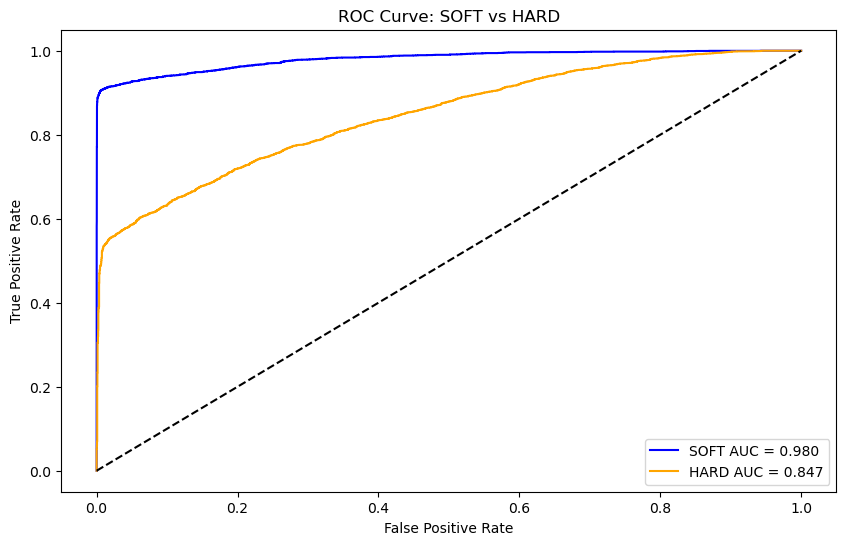

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# soft
val_probs = model.predict(X_val, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_val, val_probs)
fpr, tpr, _ = roc_curve(y_val, val_probs)
plt.plot(fpr, tpr, label=f'SOFT AUC = {roc_auc:.3f}', color='blue')

# hard
hard_val_probs = model_hard.predict(X_hard_val, num_iteration=model_hard.best_iteration)
hard_roc_auc = roc_auc_score(y_hard_val, hard_val_probs)
fpr_hard, tpr_hard, _ = roc_curve(y_hard_val, hard_val_probs)
plt.plot(fpr_hard, tpr_hard, label=f'HARD AUC = {hard_roc_auc:.3f}', color='orange')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SOFT vs HARD')
plt.legend()
plt.show()


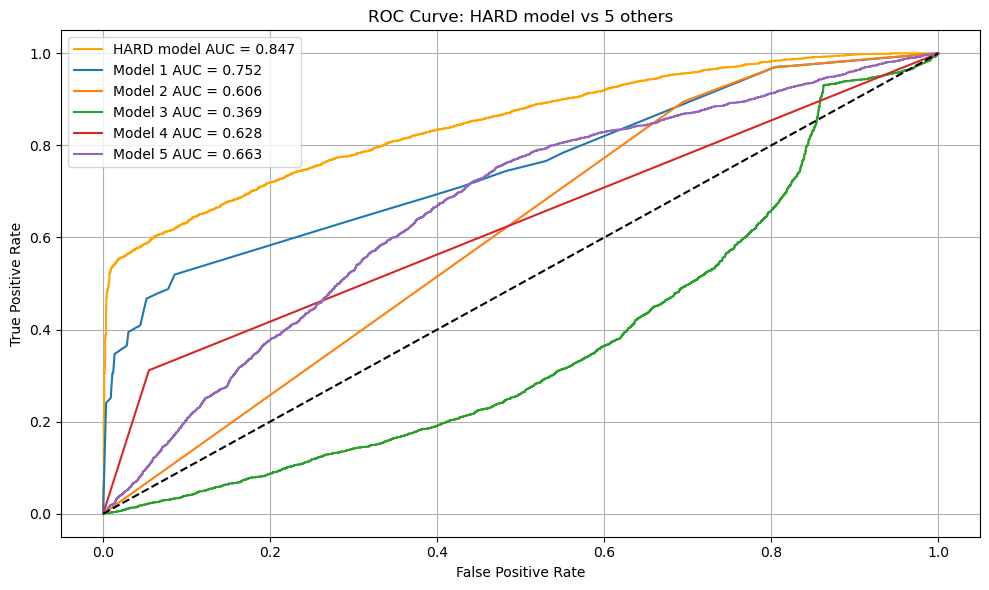

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Основная модель на HARD
hard_val_probs = model_hard.predict(X_hard_val, num_iteration=model_hard.best_iteration)
hard_roc_auc = roc_auc_score(y_hard_val, hard_val_probs)
fpr_hard, tpr_hard, _ = roc_curve(y_hard_val, hard_val_probs)
plt.plot(fpr_hard, tpr_hard, label=f'HARD model AUC = {hard_roc_auc:.3f}', color='orange')

# 5 "загадочных" моделей — предполагаем, что колонки называются model1 ... model5
for i in range(1, 6):
    col_name = f'model_{i}'
    if col_name in X_hard_val.columns:
        preds = X_hard_val[col_name]
        auc = roc_auc_score(y_hard_val, preds)
        fpr, tpr, _ = roc_curve(y_hard_val, preds)
        plt.plot(fpr, tpr, label=f'Model {i} AUC = {auc:.3f}')

# Диагональ случайного угадывания
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: HARD model vs 5 others')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Full AUC: 0.9584278092164515


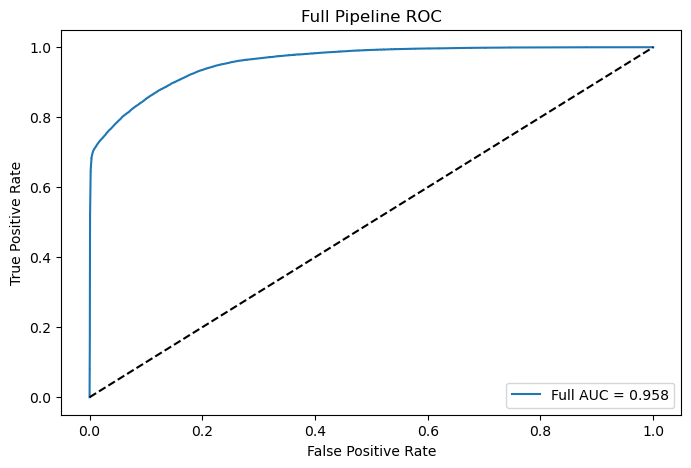

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve

# Предсказания для всего train
full_train_preds = predict_full(tr)      # та самая функция с rule+model
full_train_true  = target.values

# Общий ROC-AUC
auc_full = roc_auc_score(full_train_true, full_train_preds)
fpr, tpr, _ = roc_curve(full_train_true, full_train_preds)

print("Full AUC:", auc_full)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'Full AUC = {auc_full:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Full Pipeline ROC')
plt.legend()
plt.show()


In [7]:
tr[tr.isna().any(axis=1)]


,model_1,model_2,model_3,model_4,model_5,time_to_order_seconds,ttos_sq,ttos_cube,ttos_log,ttos_decile,...,is_midnight_session,order_during_business_hours,hour_diff,order_time_fraction,order_season,session_end_season,ttos_x_hour,ttos_x_dow,order_time_frac,hard_call
154,0.025277,0.372171,0.000047,1,0.000002,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.557153,winter,autumn,NaN,NaN,0.557153,0
864,0.025277,0.372171,0.000046,1,0.000002,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.484317,autumn,autumn,NaN,NaN,0.484317,0
911,0.025277,0.372171,0.000047,1,0.000003,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.569086,autumn,autumn,NaN,NaN,0.569086,0
1455,0.025277,0.372171,0.000046,1,0.000002,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.375660,winter,autumn,NaN,NaN,0.375660,0
1495,0.025277,0.372171,0.000046,1,0.000002,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.637546,winter,autumn,NaN,NaN,0.637546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104448,0.025277,0.372171,0.000057,1,0.000007,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.438356,winter,autumn,NaN,NaN,0.438356,0
104467,0.025277,0.372171,0.000046,1,0.000002,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.448333,winter,autumn,NaN,NaN,0.448333,0
104531,0.025277,0.372171,0.000048,1,0.000003,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.460984,autumn,autumn,NaN,NaN,0.460984,0
104554,0.025277,0.372171,0.000046,1,0.000002,NaN,NaN,NaN,NaN,NaN,...,False,True,NaN,0.488021,winter,autumn,NaN,NaN,0.488021,0


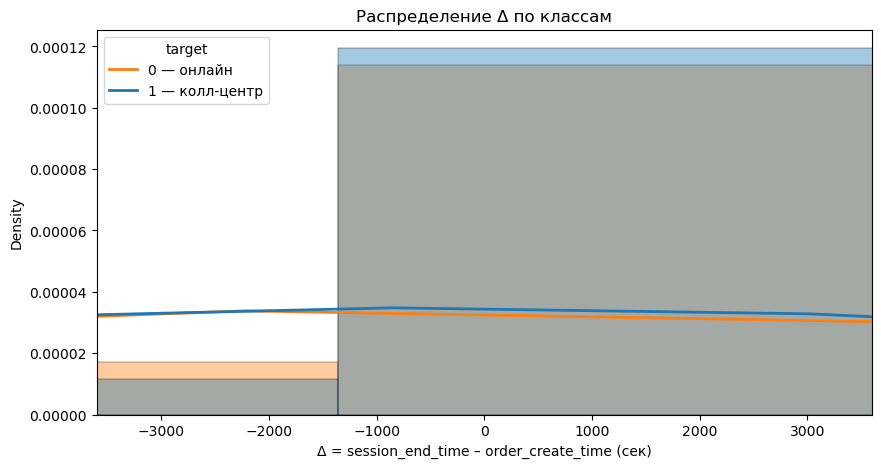

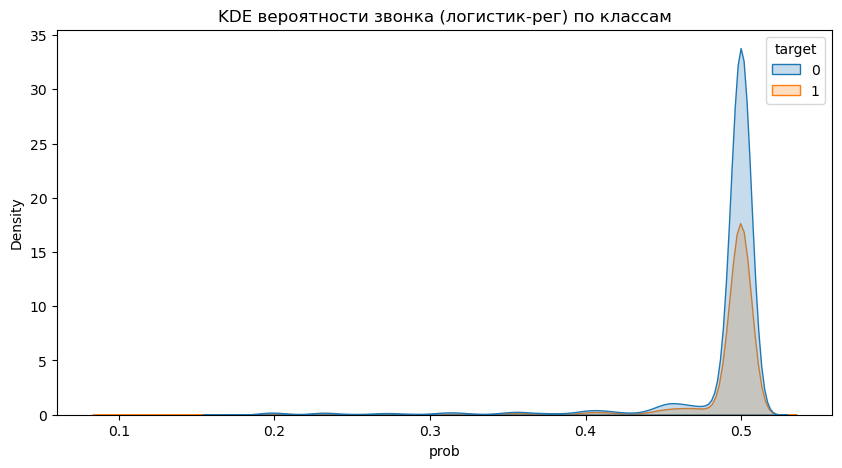

Optimal prob threshold = 0.459, TPR=0.914, FPR=0.905
Logistic AUC = 0.3630
Best rule-based thr = -210.0s, AUC = 0.6805


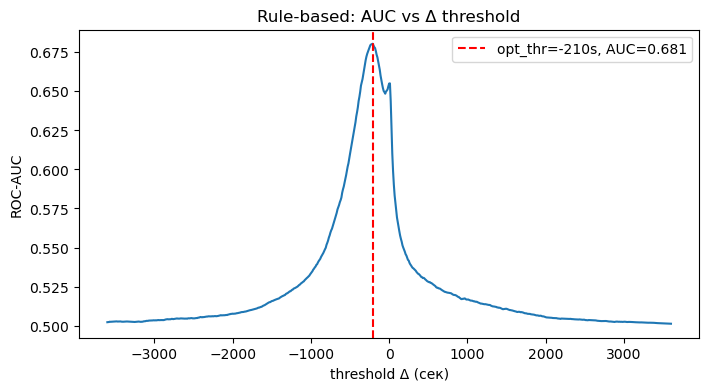

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# --- 1) Загрузка и фичи (предполагаем, что create_time_features уже есть) ---
tr = pd.read_parquet('data/train.parquet')
tr['order_create_time'] = pd.to_datetime(tr['order_create_time'])
tr['session_end_time'] = pd.to_datetime(tr['session_end_time'])
tr['time_to_order_seconds'] = (tr['session_end_time'] - tr['order_create_time']).dt.total_seconds()

tr['time_to_order_seconds'] = tr['time_to_order_seconds'].fillna(-9999)
tst['time_to_order_seconds'] = tst['time_to_order_seconds'].fillna(-9999)

y = tr['target'].values
X = tr[['time_to_order_seconds']].values.reshape(-1,1)

# --- 2) Разбиение на train/test для анализа порога ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- 3) KDE/гистограммы Δ по классам ---
plt.figure(figsize=(10,5))
sns.histplot(data=tr, x='time_to_order_seconds', hue='target',
             stat='density', common_norm=False, bins=200, alpha=0.4)
sns.kdeplot(data=tr, x='time_to_order_seconds', hue='target', common_norm=False, lw=2)
plt.xlim(-3600, 3600)
plt.title('Распределение Δ по классам')
plt.xlabel('Δ = session_end_time – order_create_time (сек)')
plt.legend(title='target', labels=['0 — онлайн','1 — колл-центр'])
plt.show()

# --- 4) Логистическая регрессия на Δ ---
lr = LogisticRegression(solver='liblinear')

lr.fit(X_train, y_train)
probs_test = lr.predict_proba(X_test)[:,1]

# KDE/гист по pred_prob
dfp = pd.DataFrame({'prob': probs_test, 'target': y_test})
plt.figure(figsize=(10,5))
sns.kdeplot(data=dfp, x='prob', hue='target', fill=True)
plt.title('KDE вероятности звонка (логистик-рег) по классам')
plt.show()

# --- 5) Поиск оптимального порога по Youden J ---
fpr, tpr, thresholds = roc_curve(y_test, probs_test)
j = tpr - fpr
ix = np.argmax(j)
best_thr = thresholds[ix]
print(f"Optimal prob threshold = {best_thr:.3f}, TPR={tpr[ix]:.3f}, FPR={fpr[ix]:.3f}")

# AUC для логиста
auc_lr = roc_auc_score(y_test, probs_test)
print(f"Logistic AUC = {auc_lr:.4f}")

# --- 6) Сравнение с простым rule-based на том же тесте ---
# правило: predict 1 если Δ <= cand_thr
def eval_rule(cand_thr):
    rule_preds = (X_test.reshape(-1) <= cand_thr).astype(int)
    return roc_auc_score(y_test, rule_preds)

# грубый scan порога
cands = np.linspace(-3600, 3600, 721)   # шаг 10 сек
scores = [eval_rule(t) for t in cands]
best_idx = np.argmax(scores)
print(f"Best rule-based thr = {cands[best_idx]:.1f}s, AUC = {scores[best_idx]:.4f}")

plt.figure(figsize=(8,4))
plt.plot(cands, scores)
plt.axvline(cands[best_idx], color='red', linestyle='--',
            label=f'opt_thr={cands[best_idx]:.0f}s, AUC={scores[best_idx]:.3f}')
plt.title('Rule-based: AUC vs Δ threshold')
plt.xlabel('threshold Δ (сек)')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()


In [9]:
import numpy as np
from sklearn.metrics import roc_auc_score

# X_full, y_full — это весь tr[['time_to_order_seconds']].values и target.values
deltas = tr['time_to_order_seconds'].values
y_full = tr['target'].values

ths = np.linspace(-3600, 0, 361)      # от −1 часа до 0 по шагу 10 сек
aucs = []
for tau in ths:
    preds = (deltas <= tau).astype(int)
    aucs.append(roc_auc_score(y_full, preds))

best_idx = np.argmax(aucs)
best_tau, best_auc = ths[best_idx], aucs[best_idx]
print(f"Optimal rule-based τ = {best_tau:.0f} сек (≈{best_tau/60:.1f} мин), AUC = {best_auc:.4f}")


Optimal rule-based τ = -210 сек (≈-3.5 мин), AUC = 0.6785


In [10]:
ы

NameError: name 'ы' is not defined

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# Загружаем и подготавливаем данные
tr = pd.read_parquet('data/train.parquet')
target = tr.pop('target')

# Фичеинжиниринг
tr = create_time_features(tr)
tr = tr.drop(columns=['order_create_time', 'session_end_time'])

threshold_hard = -2000
tr['hard_call'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)

cat_cols = tr.select_dtypes(include=['object']).columns.tolist() + [
    'order_time_of_day', 'session_end_time_of_day'
]
cat_cols = list(set(col for col in cat_cols if col in tr.columns))

for col in cat_cols:
    tr[col] = tr[col].astype('category')

# Выделяем hard-примеры
mask = tr['hard_call'] == 1
X = tr[mask].drop(columns=['hard_call'])
y = target[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)

# Оптимизация
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'seed': 42,
        'feature_pre_filter': False,

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 15, 64),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100)
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=500,
        callbacks=[
			lgb.early_stopping(stopping_rounds=50),
			lgb.log_evaluation(period=0)
		]
    )

    preds = model.predict(X_val, num_iteration=model.best_iteration)
    return roc_auc_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\nBest AUC: {:.4f}".format(study.best_value))
print("Best Params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


In [ ]:
ы